In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

import os
import glob
import os.path

import pytz

### 1. Read in the data.
<br><br>
For the sensor data, each day is a .csv file. What we want is to read in chunks all the .csv files within a folder (one folder belongs to a one sampling day, and within each folder, there are the sensor measurement for the previous 15 days) and append them all together. I have to end up with a single dataframe.

In [2]:
#path = '/Users/gemavidal/Vet/University of California, Davis/Fernanda Carolina Ferreira - Cowmanager/06022020/sensor_data/'
#path = '/Users/gemavidal/Vet/University of California, Davis/Fernanda Carolina Ferreira - Cowmanager/06302020/sensor_data/'
path = '/Users/gemavidal/Vet/University of California, Davis/Fernanda Carolina Ferreira - Cowmanager/08042020/sensor_data/'
#os.listdir(path)

complete_path = glob.glob(os.path.join(path, '*.csv'))
complete_path[0]

'/Users/gemavidal/Vet/University of California, Davis/Fernanda Carolina Ferreira - Cowmanager/08042020/sensor_data/CowManager_DeJager Farms South_20200721.csv'

In [3]:
def extract_files(f):
    
    '''This function reads in chunks a .csv file and later concatenates each chunk to create
    the dataframe. We specify the type of separation between fields in the .csv file,
    in this case, tabs.
    It is using a regular expression, so argument 'sep' equals the exact symbol the engine has to look for'''
    
    iter_csv = pd.read_csv(f, index_col = False, sep = '|', chunksize = 100000, low_memory = False)
    df = pd.concat([chunk for chunk in iter_csv])
    return df

In [4]:
# Create a list with all the dataframes using my function to read the files
all_files = [extract_files(f) for f in complete_path]

In [5]:
# Append each one of the dataframes so we end up with one single dataframe.
# Start by creating an empty dataframe
df_sensor = pd.DataFrame()
df_sensor = pd.concat(all_files)

df_sensor.shape

(1116278, 10)

In [6]:
df_sensor.head(5)

,RegistrationId,CowNumber,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature
0,8119,8119,20200720 21:00:00,60,11,31,5,7,6,36.11
1,6539,6539,20200720 21:00:00,60,60,0,0,0,0,23.94
2,9676,9676,20200720 21:00:00,61,9,18,18,7,9,34.47
3,4374,4374,20200720 21:00:00,60,3,32,3,11,11,34.89
4,4783,4783,20200720 21:00:00,61,16,27,7,6,5,33.93


<br>
### 2a. Clean the errors: find duplicate rows
<br>

In [7]:
duplicates_series = df_sensor.duplicated()
duplicates_series[duplicates_series == True]

Series([], dtype: bool)

<br>
### 2b. Clean the errors: find rows where 'MeasurementCount' is smaller than 58, or greater than 62

In [8]:
df_sensor.loc[(df_sensor['MeasurementCount'] < 58) | (df_sensor['MeasurementCount'] > 62)]

,RegistrationId,CowNumber,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature


<br>
### 3. Give consistency to the variable names
<br>

In [9]:
# Change column name in the df with cow information using a dictionary
df_sensor = df_sensor.rename(columns = {"CowNumber" : 'cow_id'})

<br>
### 4. Reduce the size of the sensor dataframe. Selecting those cows we are interested in.
<br>

Read in the dataframe with the cow data information for a given farm visit

In [10]:
#df_cow = pd.read_csv("/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_scoreDHIA.csv")
#df_cow = pd.read_csv("/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_scoreDHIA_06302020.csv")
df_cow = pd.read_csv("/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_scoreDHIA_08042020.csv")


In [11]:
df_cow.head(3)

,Unnamed: 0,date,scc_sample_id,stall_number,cow_id,hygiene_score,hygiene_score_notes,recorder,notes,date_stamp,...,Obs,labdate_stamp,freshdate_stamp,lastmovedate_stamp,dayfirstCM_stamp,daylastCM_stamp,dryoffdate_stamp,diff_dryoff_lastCM,diff_penmovement,scc_catg
0,0,4-Aug-20,1,53,7546,1,NaN,daniela,NaN,2020-08-04,...,NaN,2020-08-04,2019-10-09,2020-02-05,NaN,NaN,2020-08-04,NaN,181,0
1,1,4-Aug-20,2,54,3562,2,NaN,daniela,NaN,2020-08-04,...,NaN,2020-08-04,2019-07-21,2020-04-29,NaN,NaN,2020-08-04,NaN,97,0
2,2,4-Aug-20,3,55,2478,1,NaN,daniela,NaN,2020-08-04,...,NaN,2020-08-04,2019-10-24,2020-07-08,2020-06-10,2020-06-10,2020-08-04,55.0,27,0


In [12]:
# Merging both dataframes on cow_id. How = 'inner' so only the shared cows between both dataframes are selected in the 
# new dataframe that combines individual cow data and sensor data.
df_cow_selection = df_cow[['cow_id', 'dryoffdate_stamp']]
df_sensor_cow = pd.merge(df_sensor, df_cow_selection, on = 'cow_id', how = 'inner')

In [13]:
df_sensor_cow.dtypes

RegistrationId        int64
cow_id                int64
TimeStamp            object
MeasurementCount      int64
NotActive             int64
Ruminating            int64
Eating                int64
Active                int64
HighActive            int64
Temperature         float64
dryoffdate_stamp     object
dtype: object

In [14]:
# Change column name in the df with cow information using a dictionary. THis is to avoid errors in the future.
df_sensor_cow = df_sensor_cow.rename(columns = {'dryoffdate_stamp' : 'dryoffdate_stamp_x'})

In [15]:
df_sensor_cow.shape

(15091, 11)

In [16]:
df_sensor_cow['TimeStamp'].head(3)

0    20200720 21:00:00
1    20200720 22:00:00
2    20200720 23:00:00
Name: TimeStamp, dtype: object

In [17]:
# Change format of variable TimeStamp to a real time stamp
df_sensor_cow['date_time_stamp'] = pd.to_datetime(df_sensor_cow["TimeStamp"], format = '%Y%m%d %H:%M:%S')


Do not create the hour and day variables now. There are missing time stamps, and when created, hour and day variables will be NaN. To avoid that, just create the date_time_stamp and after creating the new complete index, then create day and hour variables

In [18]:
# Double-check the number of cows is the appropriate one
df_sensor_cow.nunique()['cow_id']

43

<br><br>
Look at how the sensor data looks like... get an idea about how much missing data there is. It is clearer to look at one single cow instead of all cows at once

<br><br>
Looking for errors or missing data using code instead of plots

In [19]:
df_sensor_cow.head(3)

,RegistrationId,cow_id,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp
0,2478,2478,20200720 21:00:00,60,28,27,0,4,1,34.66,2020-08-04,2020-07-20 21:00:00
1,2478,2478,20200720 22:00:00,60,30,4,15,5,6,35.06,2020-08-04,2020-07-20 22:00:00
2,2478,2478,20200720 23:00:00,61,0,39,9,1,12,34.97,2020-08-04,2020-07-20 23:00:00


In [20]:
# Calculate the difference in dates, to see if there are some greater than 1 hour
# First, sort in ascending order the timestamp
#df_sensor_cow = df_sensor_cow.groupby(['cow_id']).apply(lambda x: x.sort_values(by = 'date_time_stamp', ascending = True))

df_sensor_cow_sorted = df_sensor_cow.sort_values(by = ['cow_id', 'date_time_stamp'], ascending = [True, True])
df_sensor_cow_sorted.reset_index(inplace = True)

In [21]:
df_sensor_cow_sorted.head(3)

,index,RegistrationId,cow_id,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp
0,14316,400,400,20200720 20:00:00,60,45,10,0,3,2,33.69,2020-08-04,2020-07-20 20:00:00
1,14317,400,400,20200720 21:00:00,60,12,33,8,5,2,34.51,2020-08-04,2020-07-20 21:00:00
2,14321,400,400,20200720 22:00:00,60,11,21,19,8,1,34.83,2020-08-04,2020-07-20 22:00:00


<br>
Next, calculate the differences between dates. None of them should be bigger than 1 hour, otherwise it means there is missing data. None of them should be 0 either, that would mean there are duplicates
<br>

In [22]:
# Second, calculate the difference in date_time
df_sensor_cow_sorted_diff = df_sensor_cow_sorted.copy()

df_sensor_cow_sorted_diff['difference'] = df_sensor_cow_sorted_diff.groupby('cow_id')['date_time_stamp'].apply(lambda x: x.diff())

In [23]:
df_sensor_cow_sorted_diff.head(3)

,index,RegistrationId,cow_id,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp,difference
0,14316,400,400,20200720 20:00:00,60,45,10,0,3,2,33.69,2020-08-04,2020-07-20 20:00:00,NaT
1,14317,400,400,20200720 21:00:00,60,12,33,8,5,2,34.51,2020-08-04,2020-07-20 21:00:00,01:00:00
2,14321,400,400,20200720 22:00:00,60,11,21,19,8,1,34.83,2020-08-04,2020-07-20 22:00:00,01:00:00


In [27]:
#df_sensor_cow_sorted_diff.loc[(df_sensor_cow_sorted_diff['difference'] == '00:00:00')]
df_sensor_cow_sorted_diff.loc[(df_sensor_cow_sorted_diff['difference'] > '01:00:00')]
#df_sensor_cow_sorted_diff.loc[(df_sensor_cow_sorted_diff['difference'] < '00:00:00')]

,index,RegistrationId,cow_id,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp,difference


<br>
### June
There are some instances were data is missing (some cases with 10 or 15 hours difference), and there are also some instances where cows may be duplicated because the difference in time is 0 hours --> I fixed this already.
<br>
The cows with missing sensor data are: 3565 (the majority of the missing values), 7274 and 7282
<br>
Lets check the frequencies of the cow_id. That will tell us which cows are duplicates because they will have higher frequencies.
<br>
### August
There are no missing sensor data

In [27]:
#df_sensor_cow['cow_id'].value_counts()

## Fill-in the missing dates (complete the time sequence but keep the sensor data missing (not interpolating data here)
<br> First fix the non-unique rows, removing the duplicates, otherwise will not work

In [28]:
def reindex_by_date(df):
    '''Arguments:
    df: a dataframe which index is date_time timestamp. If using the whole dataframe, it wont be unique unless
        we create a multiindex with cow id.
    Creates a range of dates based on what is the minimun and maximum dates using as frequency the hours
    
    Returns:
    a dataframe where uses as index the new range of dates and for those that are missing in the original
    dataframe, will fill them out with 0'''
    idx = pd.date_range(df.index.min(), df.index.max(), freq = 'H')
    df_2 = df.reindex(idx)
    return df_2 # I don't need to specify argument 'fill_value' so it will be filled with NaN

<br>
What type of dataframe do we have now? We should change the indexes so the we end up with a dataframe with a datestamp as index that is sorted. CAREFUL here, because when reassigning index, it will go to the original one, which was not sorted.

In [29]:
df_sensor_cow_sorted.head(3)

,index,RegistrationId,cow_id,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp
0,14316,400,400,20200720 20:00:00,60,45,10,0,3,2,33.69,2020-08-04,2020-07-20 20:00:00
1,14317,400,400,20200720 21:00:00,60,12,33,8,5,2,34.51,2020-08-04,2020-07-20 21:00:00
2,14321,400,400,20200720 22:00:00,60,11,21,19,8,1,34.83,2020-08-04,2020-07-20 22:00:00


In [30]:
# Create a dataframe that uses the time stamp as index
df_2_func = df_sensor_cow_sorted.set_index(pd.DatetimeIndex(df_sensor_cow_sorted['date_time_stamp']))

df_2_func.head(3)

,index,RegistrationId,cow_id,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp
date_time_stamp,,,,,,,,,,,,,
2020-07-20 20:00:00,14316,400,400,20200720 20:00:00,60,45,10,0,3,2,33.69,2020-08-04,2020-07-20 20:00:00
2020-07-20 21:00:00,14317,400,400,20200720 21:00:00,60,12,33,8,5,2,34.51,2020-08-04,2020-07-20 21:00:00
2020-07-20 22:00:00,14321,400,400,20200720 22:00:00,60,11,21,19,8,1,34.83,2020-08-04,2020-07-20 22:00:00


In [31]:
# Use my function to create the missing dates, grouping by cow_id (this will create a multiindex, so it
# will be unique with the combination of both).
df_sensor_cow_complete = df_2_func.groupby('cow_id').apply(reindex_by_date)

In [32]:
df_sensor_cow_complete.head(3)

index  RegistrationId  cow_id          TimeStamp  \
cow_id                                                                         
400    2020-07-20 20:00:00  14316             400     400  20200720 20:00:00   
       2020-07-20 21:00:00  14317             400     400  20200720 21:00:00   
       2020-07-20 22:00:00  14321             400     400  20200720 22:00:00   

                            MeasurementCount  NotActive  Ruminating  Eating  \
cow_id                                                                        
400    2020-07-20 20:00:00                60         45          10       0   
       2020-07-20 21:00:00                60         12          33       8   
       2020-07-20 22:00:00                60         11          21      19   

                            Active  HighActive  Temperature  \
cow_id                                                        
400    2020-07-20 20:00:00       3           2        33.69   
       2020-07-20 21:00:00       5           2        34.51   
       2020-07-20 22:00:00       8           1        34.83   

                           dryoffdate_stamp_x     date_time_stamp  
cow_id                                                             
400    2020-07-20 20:00:00         2020-08-04 2020-07-20 20:00:00  
       2020-07-20 21:00:00         2020-08-04 2020-07-20 21:00:00  
       2020-07-20 22:00:00         2020-08-04 2020-07-20 22:00:00

In [33]:
# Drop column 'cow_id'
df_sensor_cow_complete.drop('cow_id', axis = 1, inplace = True)

df_sensor_cow_complete.head(3)

index  RegistrationId          TimeStamp  \
cow_id                                                                 
400    2020-07-20 20:00:00  14316             400  20200720 20:00:00   
       2020-07-20 21:00:00  14317             400  20200720 21:00:00   
       2020-07-20 22:00:00  14321             400  20200720 22:00:00   

                            MeasurementCount  NotActive  Ruminating  Eating  \
cow_id                                                                        
400    2020-07-20 20:00:00                60         45          10       0   
       2020-07-20 21:00:00                60         12          33       8   
       2020-07-20 22:00:00                60         11          21      19   

                            Active  HighActive  Temperature  \
cow_id                                                        
400    2020-07-20 20:00:00       3           2        33.69   
       2020-07-20 21:00:00       5           2        34.51   
       2020-07-20 22:00:00       8           1        34.83   

                           dryoffdate_stamp_x     date_time_stamp  
cow_id                                                             
400    2020-07-20 20:00:00         2020-08-04 2020-07-20 20:00:00  
       2020-07-20 21:00:00         2020-08-04 2020-07-20 21:00:00  
       2020-07-20 22:00:00         2020-08-04 2020-07-20 22:00:00

In [34]:
# Remove the multiindex
df_sensor_cow_complete.reset_index(inplace = True)

df_sensor_cow_complete.head(3)

,cow_id,level_1,index,RegistrationId,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp
0,400,2020-07-20 20:00:00,14316,400,20200720 20:00:00,60,45,10,0,3,2,33.69,2020-08-04,2020-07-20 20:00:00
1,400,2020-07-20 21:00:00,14317,400,20200720 21:00:00,60,12,33,8,5,2,34.51,2020-08-04,2020-07-20 21:00:00
2,400,2020-07-20 22:00:00,14321,400,20200720 22:00:00,60,11,21,19,8,1,34.83,2020-08-04,2020-07-20 22:00:00


### How do I find whether my function worked??
<br>
This is tricky: the function will have created NaN where there was no date. Therefore, I cannot take subsets of the dataframe to see whether it did worked (for example, filtering by cow_id - unless I removed the column), because those fields are now filled with NaN.
<br><br>
My strategy here is to filter by a field I know there should be data (because I already checked there were no missing values in a previous step). I choose one of the behaviors.
<br>

In [35]:
df_sensor_cow_complete.loc[(df_sensor_cow_complete['NotActive'].isnull())]

,cow_id,level_1,index,RegistrationId,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp


In [36]:
df_sensor_cow_complete.dtypes

cow_id                         int64
level_1               datetime64[ns]
index                          int64
RegistrationId                 int64
TimeStamp                     object
MeasurementCount               int64
NotActive                      int64
Ruminating                     int64
Eating                         int64
Active                         int64
HighActive                     int64
Temperature                  float64
dryoffdate_stamp_x            object
date_time_stamp       datetime64[ns]
dtype: object

<br>
Now, using the variable 'level_1', currently a time stamp, create variables hour and day

In [37]:
df_sensor_cow_complete['sensor_hour'] = df_sensor_cow_complete['level_1'].dt.hour
df_sensor_cow_complete['sensor_day'] = df_sensor_cow_complete['level_1'].dt.day

In [38]:
df_sensor_cow_complete.head(5)

,cow_id,level_1,index,RegistrationId,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,dryoffdate_stamp_x,date_time_stamp,sensor_hour,sensor_day
0,400,2020-07-20 20:00:00,14316,400,20200720 20:00:00,60,45,10,0,3,2,33.69,2020-08-04,2020-07-20 20:00:00,20,20
1,400,2020-07-20 21:00:00,14317,400,20200720 21:00:00,60,12,33,8,5,2,34.51,2020-08-04,2020-07-20 21:00:00,21,20
2,400,2020-07-20 22:00:00,14321,400,20200720 22:00:00,60,11,21,19,8,1,34.83,2020-08-04,2020-07-20 22:00:00,22,20
3,400,2020-07-20 23:00:00,14320,400,20200720 23:00:00,59,11,31,8,7,2,35.21,2020-08-04,2020-07-20 23:00:00,23,20
4,400,2020-07-21 00:00:00,14319,400,20200721 00:00:00,61,3,33,17,4,4,34.56,2020-08-04,2020-07-21 00:00:00,0,21


Drop useless variables

In [39]:
# Registration Id is just a duplicate of cow_id, dryoffdate_stamp_x comes from a trick I did so I could create
# a dataframe instead of a series, and date_time_stamp is the old time stamp that is not complete. Now, where there
# was missing data, there will be NaN
df_sensor_cow_complete.drop(['RegistrationId', 'dryoffdate_stamp_x', 'date_time_stamp'], axis = 1, inplace = True)

Rename variables

In [40]:
df_sensor_cow_complete = df_sensor_cow_complete.rename(columns = {'level_1' : 'date_time_stamp'})

### Change time zone from UTC to Los Angeles

I need to do this before updating the existing dataframe with sensor data, because that one that already exist has already been converted to L.A. timezone. That way, later I can append the new dataframe and update the existing one.

In [ ]:
# Change format of variable TimeStamp to a real time stamp
#df_sensor_cow_complete['date_time_stamp'] = pd.to_datetime(df_sensor_cow_complete['date_time_stamp'], format = '%Y%m%d %H:%M:%S')

### To Do: next time, change the variable name from 'date_time_stamp_duplicate' to 'date_time_stamp_PCT'

In [45]:
df_sensor_cow_complete['date_time_stamp_duplicate'] = df_sensor_cow_complete['date_time_stamp']
df_sensor_cow_complete.dtypes

cow_id                                int64
date_time_stamp              datetime64[ns]
index                                 int64
TimeStamp                            object
MeasurementCount                      int64
NotActive                             int64
Ruminating                            int64
Eating                                int64
Active                                int64
HighActive                            int64
Temperature                         float64
sensor_hour                           int64
sensor_day                            int64
date_time_stamp_duplicate    datetime64[ns]
dtype: object

In [46]:
df_sensor_cow_complete.set_index('date_time_stamp_duplicate', inplace = True)

In [47]:
df_sensor_cow_complete.index = df_sensor_cow_complete.index.tz_localize('UTC')
df_sensor_cow_complete.index = df_sensor_cow_complete.index.tz_convert('America/Los_Angeles')

In [48]:
df_sensor_cow_complete.reset_index(inplace = True)
df_sensor_cow_complete.head(4)

,date_time_stamp_duplicate,cow_id,date_time_stamp,index,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,sensor_hour,sensor_day
0,2020-07-20 13:00:00-07:00,400,2020-07-20 20:00:00,14316,20200720 20:00:00,60,45,10,0,3,2,33.69,20,20
1,2020-07-20 14:00:00-07:00,400,2020-07-20 21:00:00,14317,20200720 21:00:00,60,12,33,8,5,2,34.51,21,20
2,2020-07-20 15:00:00-07:00,400,2020-07-20 22:00:00,14321,20200720 22:00:00,60,11,21,19,8,1,34.83,22,20
3,2020-07-20 16:00:00-07:00,400,2020-07-20 23:00:00,14320,20200720 23:00:00,59,11,31,8,7,2,35.21,23,20


In [49]:
# Extract day and hour from the date_time_stamp_duplicate
df_sensor_cow_complete['sensor_hour_PCT'] = df_sensor_cow_complete['date_time_stamp_duplicate'].dt.hour
df_sensor_cow_complete['sensor_day_PCT'] = df_sensor_cow_complete['date_time_stamp_duplicate'].dt.day

In [50]:
df_sensor_cow_complete.head(4)

,date_time_stamp_duplicate,cow_id,date_time_stamp,index,TimeStamp,MeasurementCount,NotActive,Ruminating,Eating,Active,HighActive,Temperature,sensor_hour,sensor_day,sensor_hour_PCT,sensor_day_PCT
0,2020-07-20 13:00:00-07:00,400,2020-07-20 20:00:00,14316,20200720 20:00:00,60,45,10,0,3,2,33.69,20,20,13,20
1,2020-07-20 14:00:00-07:00,400,2020-07-20 21:00:00,14317,20200720 21:00:00,60,12,33,8,5,2,34.51,21,20,14,20
2,2020-07-20 15:00:00-07:00,400,2020-07-20 22:00:00,14321,20200720 22:00:00,60,11,21,19,8,1,34.83,22,20,15,20
3,2020-07-20 16:00:00-07:00,400,2020-07-20 23:00:00,14320,20200720 23:00:00,59,11,31,8,7,2,35.21,23,20,16,20


### Save dataframe

In [52]:
#df_sensor_cow_complete.to_csv("/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_sensor_cow_completedates_06302020.csv")
df_sensor_cow_complete.to_csv("/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_sensor_cow_completedates_08042020.csv")


<br><br>
### Read-in the sensor dataframe to do descriptives

In [53]:
#file_path = "/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_sensor_cow_completedates_06022020.csv"
#df_1 = pd.read_csv(file_path, index_col = False)

#file_path = "/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_sensor_cow_completedates_06302020.csv"
#df_2 = pd.read_csv(file_path, index_col = False)

file_path = "/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_sensor_cow_completedates_08042020.csv"
df_new = pd.read_csv(file_path, index_col = False)

file_path = "/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_sensor_cow_completedates_June2020.csv"
df_previous = pd.read_csv(file_path, index_col = False)


In [54]:
print df_previous.shape, df_new.shape

(32275, 18) (15091, 17)


In [55]:
print df_previous.columns
print df_new.columns

Index([u'Unnamed: 0', u'date_time_stamp_duplicate', u'date_time_stamp',
       u'Unnamed: 0.1', u'cow_id', u'index', u'TimeStamp', u'MeasurementCount',
       u'NotActive', u'Ruminating', u'Eating', u'Active', u'HighActive',
       u'Temperature', u'sensor_hour', u'sensor_day', u'sensor_hour_PCT',
       u'sensor_day_PCT'],
      dtype='object')
Index([u'Unnamed: 0', u'date_time_stamp_duplicate', u'cow_id',
       u'date_time_stamp', u'index', u'TimeStamp', u'MeasurementCount',
       u'NotActive', u'Ruminating', u'Eating', u'Active', u'HighActive',
       u'Temperature', u'sensor_hour', u'sensor_day', u'sensor_hour_PCT',
       u'sensor_day_PCT'],
      dtype='object')


In [56]:
df_updated = df_previous.append(df_new, ignore_index = True)
df_updated.shape

(47366, 18)

In [4]:
df_updated.head(5)

,Unnamed: 0,Active,Eating,HighActive,MeasurementCount,NotActive,Ruminating,Temperature,TimeStamp,Unnamed: 0.1,Unnamed: 0.1.1,cow_id,date_time_stamp,date_time_stamp_duplicate,index,sensor_day,sensor_day_PCT,sensor_hour,sensor_hour_PCT
0,0,1.0,31.0,14.0,60.0,13.0,1.0,24.34,20200514 21:00:00,0,0.0,172,2020-05-14 21:00:00,2020-05-14 14:00:00-07:00,6295.0,14,14,21,14
1,1,3.0,0.0,1.0,60.0,23.0,33.0,27.86,20200514 22:00:00,1,1.0,172,2020-05-14 22:00:00,2020-05-14 15:00:00-07:00,6296.0,14,14,22,15
2,2,9.0,0.0,0.0,60.0,17.0,34.0,29.86,20200514 23:00:00,2,2.0,172,2020-05-14 23:00:00,2020-05-14 16:00:00-07:00,6297.0,14,14,23,16
3,3,4.0,19.0,7.0,59.0,0.0,29.0,30.53,20200515 00:00:00,3,3.0,172,2020-05-15 00:00:00,2020-05-14 17:00:00-07:00,6298.0,15,14,0,17
4,4,12.0,0.0,3.0,59.0,32.0,12.0,31.33,20200515 01:00:00,4,4.0,172,2020-05-15 01:00:00,2020-05-14 18:00:00-07:00,6299.0,15,14,1,18


### Save new dataframe with the updated sensor data

In [65]:
df_updated.to_csv("/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_sensor_cow_completedates_August2020.csv")


In [3]:
file_path = "/Users/gemavidal/Box Sync/Vet/Projects and Papers/2021 Chapter 4 Dissertation High SCC Prediciton Udder Hygiene/df_sensor_cow_completedates_August2020.csv"
df_updated = pd.read_csv(file_path, index_col = False)

In [17]:
df_updated.loc[(df_updated['sensor_day_PCT'] == 4)]

,Unnamed: 0,Active,Eating,HighActive,MeasurementCount,NotActive,Ruminating,Temperature,TimeStamp,Unnamed: 0.1,Unnamed: 0.1.1,cow_id,date_time_stamp,date_time_stamp_duplicate,index,sensor_day,sensor_day_PCT,sensor_hour,sensor_hour_PCT
32622,32622,11.0,7.0,7.0,59.0,25.0,9.0,28.59,20200804 07:00:00,347,NaN,400,2020-08-04 07:00:00,2020-08-04 00:00:00-07:00,14657.0,4,4,7,0
32623,32623,1.0,0.0,0.0,60.0,33.0,26.0,29.86,20200804 08:00:00,348,NaN,400,2020-08-04 08:00:00,2020-08-04 01:00:00-07:00,14664.0,4,4,8,1
32624,32624,4.0,0.0,0.0,61.0,42.0,15.0,29.37,20200804 09:00:00,349,NaN,400,2020-08-04 09:00:00,2020-08-04 02:00:00-07:00,14665.0,4,4,9,2
32625,32625,6.0,0.0,3.0,60.0,30.0,21.0,29.16,20200804 10:00:00,350,NaN,400,2020-08-04 10:00:00,2020-08-04 03:00:00-07:00,14666.0,4,4,10,3
32626,32626,0.0,0.0,0.0,60.0,28.0,32.0,29.62,20200804 11:00:00,351,NaN,400,2020-08-04 11:00:00,2020-08-04 04:00:00-07:00,14667.0,4,4,11,4
32627,32627,3.0,4.0,2.0,61.0,51.0,1.0,28.54,20200804 12:00:00,352,NaN,400,2020-08-04 12:00:00,2020-08-04 05:00:00-07:00,14668.0,4,4,12,5
32628,32628,6.0,21.0,21.0,60.0,6.0,6.0,27.41,20200804 13:00:00,353,NaN,400,2020-08-04 13:00:00,2020-08-04 06:00:00-07:00,14669.0,4,4,13,6
32975,32975,14.0,8.0,16.0,60.0,6.0,16.0,28.48,20200804 07:00:00,700,NaN,674,2020-08-04 07:00:00,2020-08-04 00:00:00-07:00,8543.0,4,4,7,0
32976,32976,3.0,0.0,0.0,61.0,29.0,29.0,29.27,20200804 08:00:00,701,NaN,674,2020-08-04 08:00:00,2020-08-04 01:00:00-07:00,8544.0,4,4,8,1
32977,32977,2.0,0.0,0.0,60.0,45.0,13.0,28.58,20200804 09:00:00,702,NaN,674,2020-08-04 09:00:00,2020-08-04 02:00:00-07:00,8545.0,4,4,9,2


<br>
## Descriptive statistics for the sensor data
<br>

In [58]:
sns.set(rc={'figure.figsize':(11,8)})

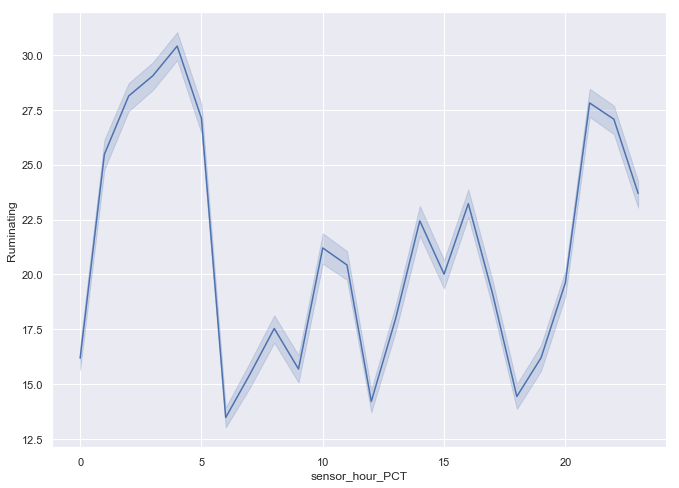

In [59]:
ax = sns.lineplot(x = 'sensor_hour_PCT', y = 'Ruminating', data = df_updated)
                  #hue = 'parity_catg', style = 'parity_catg', markers = True, dashes = False)

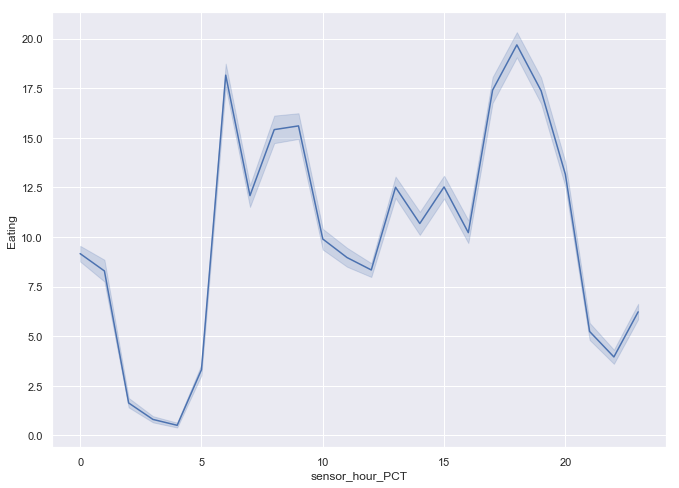

In [60]:
ax = sns.lineplot(x = 'sensor_hour_PCT', y = 'Eating', data = df_updated)
                  #hue = 'parity_catg', style = 'parity_catg', markers = True, dashes = False)

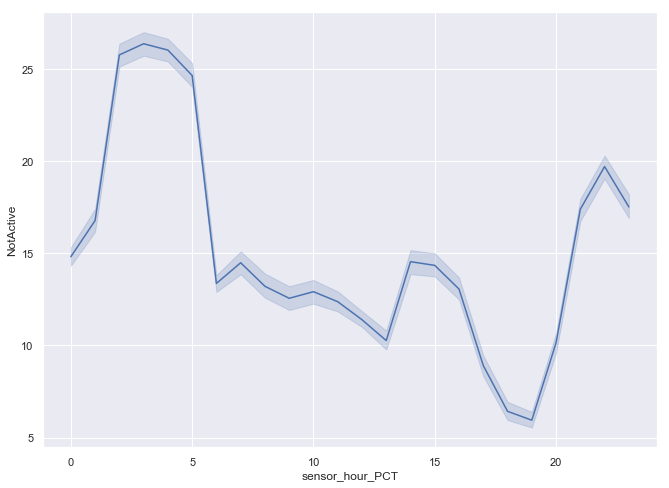

In [61]:
ax = sns.lineplot(x = 'sensor_hour_PCT', y = 'NotActive', data = df_updated)
                  #hue = 'parity_catg', style = 'parity_catg', markers = True, dashes = False)

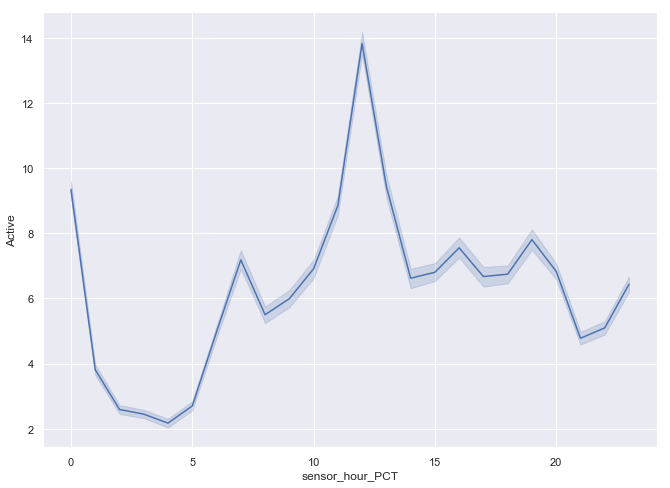

In [62]:
ax = sns.lineplot(x = 'sensor_hour_PCT', y = 'Active', data = df_updated)
                  #hue = 'parity_catg', style = 'parity_catg', markers = True, dashes = False)

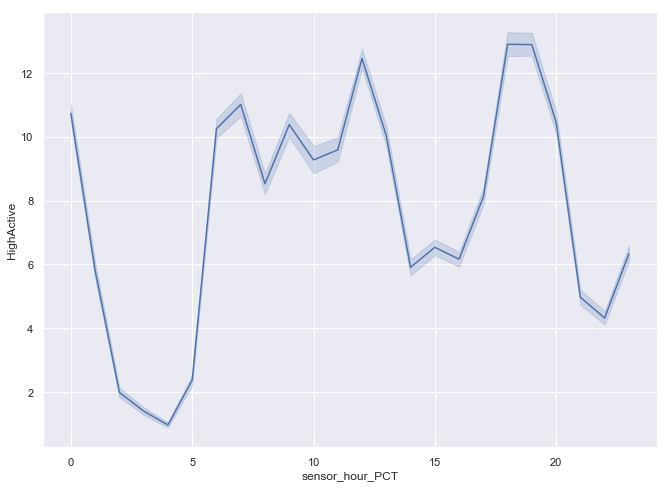

In [63]:
ax = sns.lineplot(x = 'sensor_hour_PCT', y = 'HighActive', data = df_updated)
                  #hue = 'parity_catg', style = 'parity_catg', markers = True, dashes = False)

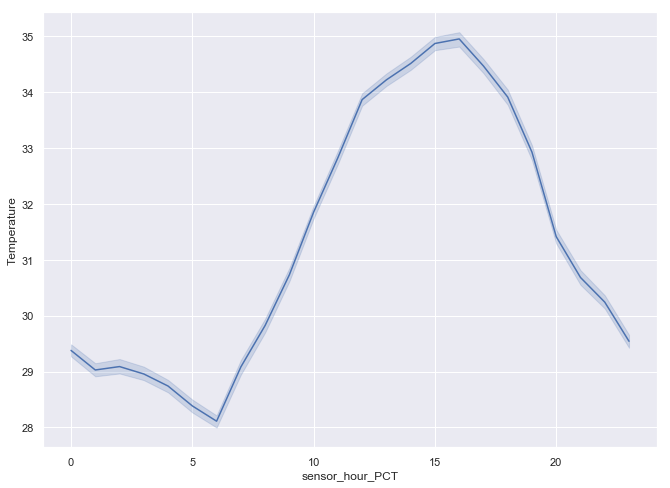

In [64]:
ax = sns.lineplot(x = 'sensor_hour_PCT', y = 'Temperature', data = df_updated)
                  #hue = 'parity_catg', style = 'parity_catg', markers = True, dashes = False)